In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
X_train[0].shape, y_train[0].shape

((28, 28), ())

In [5]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [7]:
X_train[0].shape, y_train[0].shape

((28, 28, 1), ())

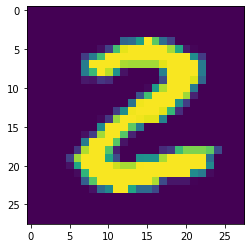

In [11]:
plt.imshow(tf.squeeze(X_train[25]));

In [12]:
y_train[25]

2

In [13]:
def plot_one_img(img_idx=0):
  plt.figure(figsize=(3, 3))
  plt.imshow(tf.squeeze(X_train[img_idx]), cmap=plt.cm.binary)
  plt.title(y_train[img_idx])
  plt.axis(False)
  plt.show()

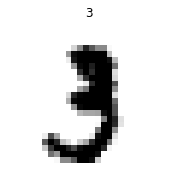

In [14]:
plot_one_img(10)

In [15]:
print(f"Before normalization: Min: {X_train.min()} -- Max: {X_train.max()}")
xmax = X_train.max()
X_train = X_train / xmax
X_test = X_test / xmax
print(f"After normalization: Min: {X_train.min()} -- Max: {X_train.max()}")

Before normalization: Min: 0 -- Max: 255
After normalization: Min: 0.0 -- Max: 1.0


In [16]:
# CNN model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input((28, 28, 1)),

    tf.keras.layers.Conv2D(8, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(.5),

    tf.keras.layers.Dense(10, activation="softmax"),
])

# Compile the model
model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fitting the model
batch_size = 256
epochs = 16
history_1 = model_1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=0
)

In [17]:
score = model_1.evaluate(X_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0362
Test accuracy : 0.9877


In [18]:
df_model1 = pd.DataFrame(history_1.history)
df_model1.head()

,loss,accuracy,val_loss,val_accuracy
0,0.794279,0.747383,0.159301,0.9540
1,0.270202,0.917583,0.098305,0.9696
2,0.206890,0.937583,0.076511,0.9743
3,0.172925,0.947833,0.064855,0.9791
4,0.153036,0.953667,0.057195,0.9806


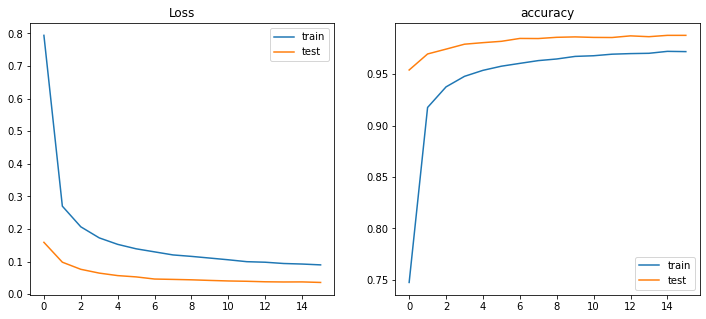

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model1)), df_model1.loss, label="train")
plt.plot(range(len(df_model1)), df_model1.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model1)), df_model1.accuracy, label="train")
plt.plot(range(len(df_model1)), df_model1.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

In [21]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

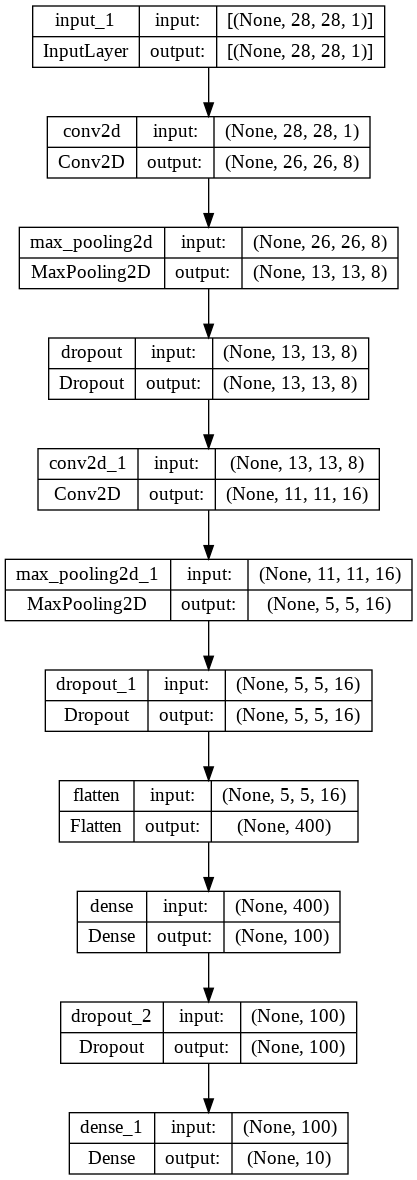

In [23]:
from tensorflow.keras.utils import plot_model

# See the inputs and outputs of each layer
plot_model(model_1, show_shapes=True)
